In [1]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper

from utils import make_env, ConvertTypeObservation


num_stack = 4
# skipframe_div = 10

env = make_env(num_stack=num_stack, truncate_on_shiphit=True)
env = ConvertTypeObservation(env)
env = GymWrapper(env)
tf_env = TFPyEnvironment(env)

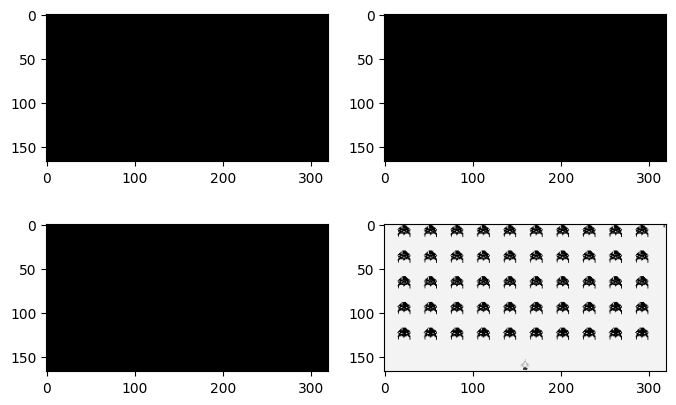

In [2]:
import tensorflow as tf

from matplotlib import pyplot as plt


obs = tf_env.reset()

# action = tf_env.action_space.sample()
obs = tf_env.step(3)[3]

plt.figure(figsize=(8, 5))
for i in range(1, num_stack+1):
    plt.subplot(2, 2, i)
    plt.imshow(tf.cast(obs[0, ..., i-1], "uint8"), cmap="gray")

In [3]:
from tensorflow.keras import layers

from tf_agents.networks.actor_distribution_network import ActorDistributionNetwork
from tf_agents.networks.value_network import ValueNetwork


preprocessing_layer = layers.Lambda(lambda obs: tf.cast(obs, tf.float32) / 255.)
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 2), (128, (3, 3), 2), (128, (3, 3), 1)]
fc_layer_params=[512]

actor_net = ActorDistributionNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)

value_net = ValueNetwork(
    tf_env.observation_spec(),
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)

In [4]:
train_iters = 50_000
update_period = 20
buffer_size = 65_000

num_epochs = 12
batch_size = 64
lr = 3e-5

In [5]:
from tensorflow.keras import optimizers

from tf_agents.agents.ppo.ppo_agent import PPOAgent


train_step = tf.Variable(0)

optimizer = optimizers.Adam(learning_rate=lr)

agent = PPOAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    optimizer=optimizer,
    actor_net=actor_net,
    value_net=value_net,
    num_epochs=num_epochs,
    train_step_counter=train_step,
    normalize_observations=True,
    normalize_rewards=True
)

agent.initialize()

In [6]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer


replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=buffer_size
)
replay_buffer_observer = replay_buffer.add_batch

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [7]:
from tf_agents.metrics import tf_metrics
from tf_agents.eval.metric_utils import log_metrics

import logging


class ShowProgress:

    def __init__(self, total):
        self.counter = 0
        self.total = total
        
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")
            

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [8]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver


collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period
)

init_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(buffer_size//4)],
    num_steps=buffer_size//4
)

final_time_step, final_policy_state = init_driver.run()

16200/16250

In [9]:
from tf_agents.utils.common import function


collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [10]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)

    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        
        train_loss = agent.train(trajectories)

        print("\r{} loss:{:.5f}".format(iteration, train_loss.loss.numpy()), end="")

        if iteration % (n_iterations//50) == 0:
            log_metrics(train_metrics)

    log_metrics(train_metrics)
    tf.saved_model.save(agent._actor_net, f"models/Alien Invasion ppo ({n_iterations} iters)/actor net TF-Agents")
    tf.saved_model.save(agent._value_net, f"models/Alien Invasion ppo ({n_iterations} iters)/value net TF-Agents")

In [11]:
train_agent(n_iterations=train_iters)

INFO:absl: 
		 NumberOfEpisodes = 1
		 EnvironmentSteps = 20
		 AverageReturn = -601.0599975585938
		 AverageEpisodeLength = 13.0


999 loss:-0.18425

INFO:absl: 
		 NumberOfEpisodes = 12
		 EnvironmentSteps = 20020
		 AverageReturn = -565.8275756835938
		 AverageEpisodeLength = 1675.4000244140625


1999 loss:-0.21356

INFO:absl: 
		 NumberOfEpisodes = 24
		 EnvironmentSteps = 40020
		 AverageReturn = -566.9017944335938
		 AverageEpisodeLength = 1677.5999755859375


2999 loss:0.029267

INFO:absl: 
		 NumberOfEpisodes = 36
		 EnvironmentSteps = 60020
		 AverageReturn = -560.1780395507812
		 AverageEpisodeLength = 1723.5


3999 loss:-0.10106

INFO:absl: 
		 NumberOfEpisodes = 47
		 EnvironmentSteps = 80020
		 AverageReturn = -570.0421142578125
		 AverageEpisodeLength = 1746.5999755859375


4999 loss:-0.15195

INFO:absl: 
		 NumberOfEpisodes = 59
		 EnvironmentSteps = 100020
		 AverageReturn = -563.271484375
		 AverageEpisodeLength = 1726.5


5999 loss:0.027766

INFO:absl: 
		 NumberOfEpisodes = 72
		 EnvironmentSteps = 120020
		 AverageReturn = -556.9981689453125
		 AverageEpisodeLength = 1523.199951171875


7000 loss:0.052949

INFO:absl: 
		 NumberOfEpisodes = 83
		 EnvironmentSteps = 140020
		 AverageReturn = -571.177001953125
		 AverageEpisodeLength = 1813.0


7999 loss:-0.01732

INFO:absl: 
		 NumberOfEpisodes = 94
		 EnvironmentSteps = 160020
		 AverageReturn = -558.4927978515625
		 AverageEpisodeLength = 1683.0999755859375


8999 loss:0.054001

INFO:absl: 
		 NumberOfEpisodes = 106
		 EnvironmentSteps = 180020
		 AverageReturn = -558.3005981445312
		 AverageEpisodeLength = 1666.300048828125


9999 loss:-0.04665

INFO:absl: 
		 NumberOfEpisodes = 118
		 EnvironmentSteps = 200020
		 AverageReturn = -559.0352783203125
		 AverageEpisodeLength = 1667.5


11000 loss:0.012208

INFO:absl: 
		 NumberOfEpisodes = 129
		 EnvironmentSteps = 220020
		 AverageReturn = -571.01220703125
		 AverageEpisodeLength = 1794.4000244140625


11999 loss:-0.05622

INFO:absl: 
		 NumberOfEpisodes = 141
		 EnvironmentSteps = 240020
		 AverageReturn = -567.7830810546875
		 AverageEpisodeLength = 1696.199951171875


12999 loss:0.036961

INFO:absl: 
		 NumberOfEpisodes = 152
		 EnvironmentSteps = 260020
		 AverageReturn = -569.2696533203125
		 AverageEpisodeLength = 1809.4000244140625


13999 loss:-0.06519

INFO:absl: 
		 NumberOfEpisodes = 162
		 EnvironmentSteps = 280020
		 AverageReturn = -582.0728759765625
		 AverageEpisodeLength = 1851.5


14999 loss:0.038650

INFO:absl: 
		 NumberOfEpisodes = 173
		 EnvironmentSteps = 300020
		 AverageReturn = -585.3343505859375
		 AverageEpisodeLength = 1854.4000244140625


15999 loss:-0.09281

INFO:absl: 
		 NumberOfEpisodes = 184
		 EnvironmentSteps = 320020
		 AverageReturn = -584.4239501953125
		 AverageEpisodeLength = 1901.0


16999 loss:-0.12285

INFO:absl: 
		 NumberOfEpisodes = 194
		 EnvironmentSteps = 340020
		 AverageReturn = -566.961181640625
		 AverageEpisodeLength = 1844.0999755859375


17999 loss:-0.03821

INFO:absl: 
		 NumberOfEpisodes = 205
		 EnvironmentSteps = 360020
		 AverageReturn = -559.07080078125
		 AverageEpisodeLength = 1835.0


18999 loss:-0.05672

INFO:absl: 
		 NumberOfEpisodes = 216
		 EnvironmentSteps = 380020
		 AverageReturn = -571.7335815429688
		 AverageEpisodeLength = 1854.5999755859375


19999 loss:0.003924

INFO:absl: 
		 NumberOfEpisodes = 227
		 EnvironmentSteps = 400020
		 AverageReturn = -573.767333984375
		 AverageEpisodeLength = 1802.199951171875


20999 loss:0.034393

INFO:absl: 
		 NumberOfEpisodes = 238
		 EnvironmentSteps = 420020
		 AverageReturn = -571.6721801757812
		 AverageEpisodeLength = 1901.0


21999 loss:-0.09889

INFO:absl: 
		 NumberOfEpisodes = 248
		 EnvironmentSteps = 440020
		 AverageReturn = -563.2518310546875
		 AverageEpisodeLength = 1886.800048828125


22999 loss:0.043377

INFO:absl: 
		 NumberOfEpisodes = 260
		 EnvironmentSteps = 460020
		 AverageReturn = -548.0878295898438
		 AverageEpisodeLength = 1762.0


23999 loss:-0.03532

INFO:absl: 
		 NumberOfEpisodes = 270
		 EnvironmentSteps = 480020
		 AverageReturn = -544.6945190429688
		 AverageEpisodeLength = 1901.0


24999 loss:-0.09094

INFO:absl: 
		 NumberOfEpisodes = 281
		 EnvironmentSteps = 500020
		 AverageReturn = -545.1111450195312
		 AverageEpisodeLength = 1756.4000244140625


26000 loss:-0.68481

INFO:absl: 
		 NumberOfEpisodes = 292
		 EnvironmentSteps = 520020
		 AverageReturn = -534.7557373046875
		 AverageEpisodeLength = 1853.699951171875


26999 loss:-0.05155

INFO:absl: 
		 NumberOfEpisodes = 303
		 EnvironmentSteps = 540020
		 AverageReturn = -540.2696533203125
		 AverageEpisodeLength = 1901.0


27999 loss:0.066698

INFO:absl: 
		 NumberOfEpisodes = 313
		 EnvironmentSteps = 560020
		 AverageReturn = -532.5070190429688
		 AverageEpisodeLength = 1901.0


28999 loss:0.048584

INFO:absl: 
		 NumberOfEpisodes = 324
		 EnvironmentSteps = 580020
		 AverageReturn = -524.4351806640625
		 AverageEpisodeLength = 1859.0999755859375


29999 loss:-0.06076

INFO:absl: 
		 NumberOfEpisodes = 335
		 EnvironmentSteps = 600020
		 AverageReturn = -516.973388671875
		 AverageEpisodeLength = 1854.199951171875


30999 loss:0.126936

INFO:absl: 
		 NumberOfEpisodes = 346
		 EnvironmentSteps = 620020
		 AverageReturn = -523.0928955078125
		 AverageEpisodeLength = 1868.5


31999 loss:-0.16231

INFO:absl: 
		 NumberOfEpisodes = 356
		 EnvironmentSteps = 640020
		 AverageReturn = -518.3433837890625
		 AverageEpisodeLength = 1901.0


32999 loss:-0.06198

INFO:absl: 
		 NumberOfEpisodes = 367
		 EnvironmentSteps = 660020
		 AverageReturn = -517.4937133789062
		 AverageEpisodeLength = 1851.800048828125


33999 loss:-0.10574

INFO:absl: 
		 NumberOfEpisodes = 378
		 EnvironmentSteps = 680020
		 AverageReturn = -509.6341857910156
		 AverageEpisodeLength = 1849.300048828125


34999 loss:0.013609

INFO:absl: 
		 NumberOfEpisodes = 390
		 EnvironmentSteps = 700020
		 AverageReturn = -503.7649841308594
		 AverageEpisodeLength = 1784.699951171875


35999 loss:-0.00713

INFO:absl: 
		 NumberOfEpisodes = 400
		 EnvironmentSteps = 720020
		 AverageReturn = -503.75848388671875
		 AverageEpisodeLength = 1820.0999755859375


36999 loss:-0.07688

INFO:absl: 
		 NumberOfEpisodes = 412
		 EnvironmentSteps = 740020
		 AverageReturn = -510.1216735839844
		 AverageEpisodeLength = 1803.0999755859375


37999 loss:0.040525

INFO:absl: 
		 NumberOfEpisodes = 423
		 EnvironmentSteps = 760020
		 AverageReturn = -502.53961181640625
		 AverageEpisodeLength = 1804.800048828125


38141 loss:-0.06924

In [ ]:
frames = []

tf_env.pyenv.envs[0].reset()

def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render())

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(10_000)],
    num_steps=10_000)
final_time_step, final_policy_state = watch_driver.run()

In [ ]:
import PIL

import os


image_path = os.path.join("rl videos", f"alieninvasion_ppo_tfagents_{train_iters}.gif")

frame_images = []
for frame in frames:
    frame.shape = frame.shape[:-1]
    frame_images.append(PIL.Image.fromarray(frame))

frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)